In [1]:
import osmnx as ox
import networkx as nx

In [2]:
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import split
import pprint

line = LineString([(1,0),(2,0),(2,1),(3,1),(3,2)])
point = line.interpolate(3.15)
print line.distance(point) == 0
print LineString([line.coords[0],point.coords[:][0]])
print LineString([point.coords[:][0], line.coords[-1]])

result = split(line, point)
print point.wkt
print line.wkt
print result[1]

True
LINESTRING (1 0, 3 1.15)
LINESTRING (3 1.15, 3 2)
POINT (3 1.15)
LINESTRING (1 0, 2 0, 2 1, 3 1, 3 2)
LINESTRING (3 1.15, 3 2)


In [3]:
# from shapely docs
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [4]:
import pandas as pd
stations = pd.read_csv("CTA_-_System_Information_-_List_of__L__Stops.csv")

In [5]:
stations["x"] = stations.Location.map(lambda x: float(x.split(",")[1][:-1]))
stations["y"] = stations.Location.map(lambda x: float(x.split(",")[0][1:]))

In [46]:
walk_filter = '["area"!~"yes"]["highway"!~"cycleway|motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["service"!~"private|alley|parking_aisle|parking"]["access"!~"private"]'
GREATER_CHI = ox.graph_from_bbox(42.074942, 41.643919, -87.523984, -87.913758, custom_filter=walk_filter)
CHI = ox.graph_from_place('Chicago, Illinois', custom_filter=walk_filter)
LW = ox.graph_from_place('Lincolnwood, Illinois', custom_filter=walk_filter)
SK = ox.graph_from_place('Skokie, Illinois', custom_filter=walk_filter)
EV = ox.graph_from_place('Evanston, Illinois', custom_filter=walk_filter)
OP = ox.graph_from_place('Oak Park, Illinois', custom_filter=walk_filter)
CI = ox.graph_from_place('Cicero, Illinois', custom_filter=walk_filter)
RO = ox.graph_from_place('Rosemont, Illinois', custom_filter=walk_filter)
FP = ox.graph_from_place('Forest Park, Illinois', custom_filter=walk_filter)

In [59]:
stations.drop_duplicates(subset=['MAP_ID'], inplace=True)
nearest_nodes = ox.utils.get_nearest_nodes(GREATER_CHI, stations.x, stations.y, method='balltree')
station_node = {mid: nn for mid, nn in zip(stations.MAP_ID, nearest_nodes)}

In [9]:
from networkx.utils import groups

# modification of nx.voronoi_cells to each node in the Voronoi cell centered at 
# `center_nodes`, along with the length of the path to each node
def voronoi_cells_lengths(G, center_nodes, weight='weight'):
    # shortest paths from center nodes to every other node
    lengths, paths = nx.multi_source_dijkstra(G, center_nodes, weight=weight)
    
    # center node from which shortest path originates and the length of that path
    nearest_lens = {(n, lengths[n]): p[0] for n, p in paths.items()}
    
    # map center nodes to all nodes closer to it than any other center nodes
    # along with the length of the path to each of those nodes
    cells = groups(nearest_lens)

    # check for unreachable nodes
    unreachable = set(G) - set(n for n, l in nearest_lens)
    if unreachable:
        cells['unreachable'] = unreachable
    return cells

In [60]:
cta_voronoi = voronoi_cells_lengths(GREATER_CHI, list(nearest_nodes), weight='length')

In [61]:
if 'unreachable' in cta_voronoi:
    GREATER_CHI.remove_nodes_from(cta_voronoi['unreachable'])
    del cta_voronoi['unreachable']

In [62]:
nearest = {x[0]: k for k, v in cta_voronoi.items() for x in v}

adjacency = set()
for node1, node2 in GREATER_CHI.edges():
    center1 = nearest[node1]
    center2 = nearest[node2]
    
    if center1 != center2:
        # order doesn't matter
        adjacency.add((center1, center2))

voronoiG = nx.Graph()
voronoiG.add_edges_from(adjacency)

In [63]:
cmap = nx.coloring.greedy_color(voronoiG)
cell_colors = ox.get_colors(n=len(set(cmap.values())), cmap='tab10', start=0.3, return_hex=True)

In [64]:
node_colors = {}
for cell, nodes_lengths in cta_voronoi.items():
    for n, l in nodes_lengths:
        node_colors[n] = cmap[cell] #cell_colors[cmap[cell]]

shortest_lens = {x[0]: x[1] for k, v in cta_voronoi.items() for x in v}
for n, d in GREATER_CHI.nodes.data():
    d['shortest'] = shortest_lens[n] 

delete_edges = []
add_edges = []
add_nodes = []
nodes = GREATER_CHI.nodes()
for node1, node2, data in GREATER_CHI.edges.data():
    cell1_color = node_colors[node1]
    cell2_color = node_colors[node2]
    if cell1_color == cell2_color:
        data['color'] = cell1_color #saves as int 0-4, so you can map color later
        #blank_edges.append((node1, node2))
    else:
        if 'geometry' in data:
            line = data['geometry']
        else:
            line = LineString([Point(nodes[node1]['x'], nodes[node1]['y']), Point(nodes[node2]['x'], nodes[node2]['y'])])
        add_to_node1 = (nodes[node2]['shortest'] + data['length'] - nodes[node1]['shortest']) * 0.5
        cut_dist = line.length * (add_to_node1 / data['length'])
        if cut_dist <= 0.0:
            data['color'] = cell2_color
        elif cut_dist >= line.length:
            data['color'] = cell1_color
        else:
            seg1, seg2 = cut(line, cut_dist)    
            delete_edges.append((node1, node2))
            add_nodes.append((-1 * node1, {'x': seg1.coords[-1][0], 'y': seg1.coords[-1][1], 'osmid': -1 * nodes[node1]['osmid']}))
            add_edges.append((node1, -1 * node1, {'geometry': seg1, 'length': data['length'] + add_to_node1, 'color': cell1_color, 'osmid': data['osmid']}))
            add_edges.append((-1 * node1, node2, {'geometry': seg2, 'length': data['length'] + (1 - add_to_node1), 'color': cell2_color, 'osmid': -1 * data['osmid']}))

GREATER_CHI.add_nodes_from(add_nodes)
GREATER_CHI.remove_edges_from(delete_edges)
GREATER_CHI.add_edges_from(add_edges)

nc = [cell_colors[node_colors[n]] if n in node_colors else 'none' for n in GREATER_CHI.nodes()]
ns = [50 if n in cta_voronoi else 0 for n in GREATER_CHI.nodes()]
ec = [cell_colors[c] for n1, n2, c in GREATER_CHI.edges.data('color')]

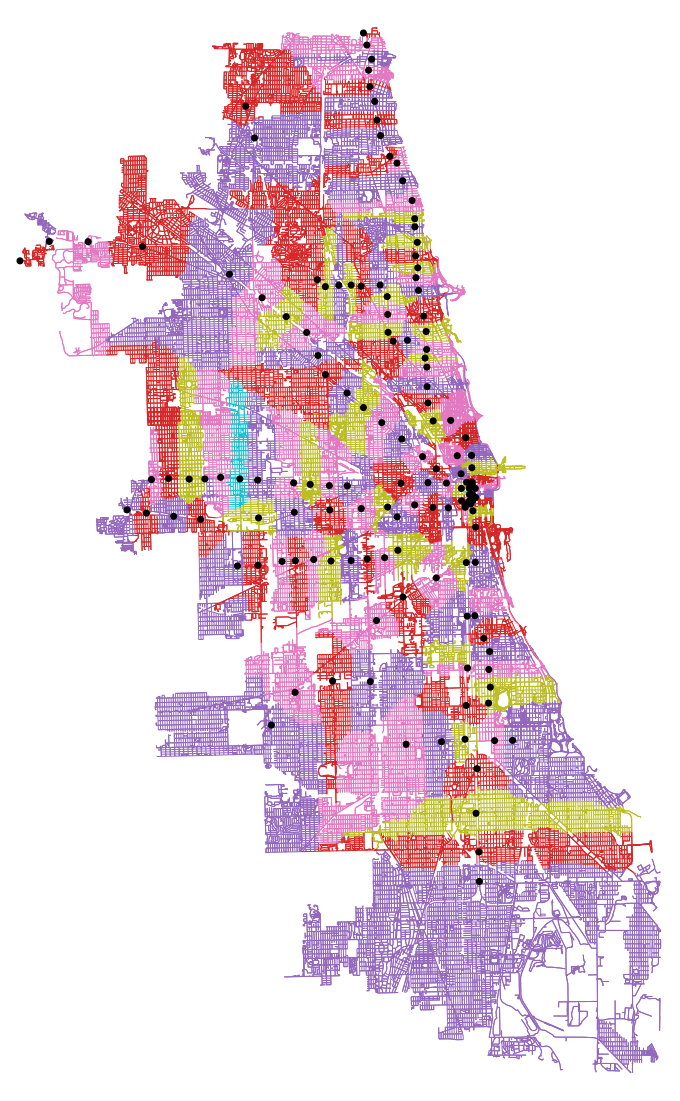

In [67]:
fig, ax = ox.plot_graph(GREATER_CHI, fig_height=20, node_color="#000000", node_size=ns, node_zorder=2, edge_color=ec)

In [65]:
CHI.add_nodes_from(add_nodes)
#GREATER_CHI = nx.compose_all([LW, SK, EV, OP, CI, RO, FP, CHI])
flattened = [n for g in [LW, SK, EV, OP, CI, RO, FP, CHI] for n in g.nodes()]

In [66]:
INDUCED_CHI = ox.utils.induce_subgraph(GREATER_CHI, flattened)

In [82]:
ns2 = [50 if node in cta_voronoi else 0 for node in INDUCED_CHI.nodes()]
ec2 = [cell_colors[c] for n1, n2, c in INDUCED_CHI.edges.data('color')]

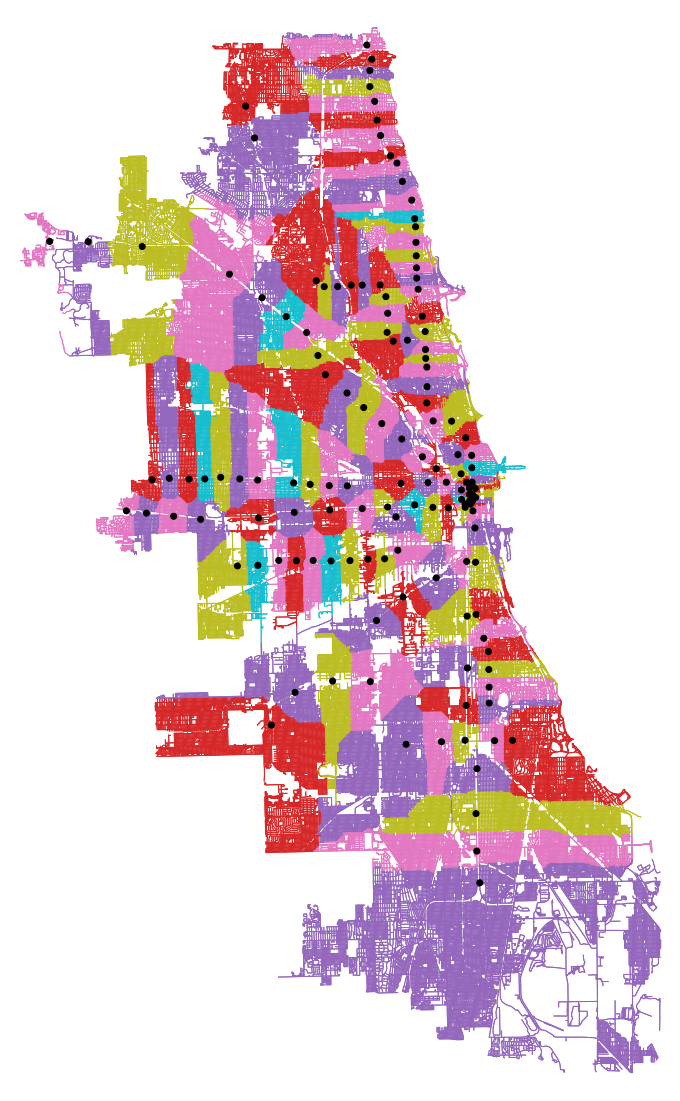

In [83]:
fig, ax = ox.plot_graph(INDUCED_CHI, fig_height=20, node_color="#000000", node_size=ns2, node_zorder=2, edge_color=ec2)

In [68]:
remove_attrs = [
    'access',
    'area',
    'bridge',
    'highway',
    'from',
    'junction',
    'key',
    'landuse',
    'lanes',
    'maxspeed',
    'name',
    'oneway',
    'ref',
    'service',
    'to',
    'tunnel',
    'width',
]

for n1, n2, d in GREATER_CHI.edges.data():
    for attr in remove_attrs:
        if attr in d:
            del d[attr]
            
for n, d in GREATER_CHI.node.data():
    for attr in remove_attrs:
        if attr in d:
            del d[attr]

In [69]:
ox.save_graph_shapefile(GREATER_CHI, filename='cta_voronoi2')

In [1]:
import geopandas as gpd

In [70]:
gdf = gpd.read_file("data/cta_voronoi2/edges/edges.geojson")

In [72]:
dissolved = gdf.dissolve(by='color')

In [73]:
dissolved.reset_index()[["color", "geometry"]].to_file("data/cta_voronoi2/edges/dissolved.geojson", driver="GeoJSON")

In [71]:
gdf.reset_index()[["color", "geometry"]].to_file("data/cta_voronoi2/edges/simplified.geojson", driver="GeoJSON")
# simplify output further to 25% in mapshaper

In [81]:
sgdf = gpd.GeoDataFrame(stations["STATION_DESCRIPTIVE_NAME"], geometry=[Point(xy) for xy in zip(stations.x, stations.y)])

In [82]:
sgdf.to_file("stations.geojson", driver="GeoJSON")

In [35]:
lines = gpd.read_file("data/CTA_RailLines.shp")

In [36]:
lines.head()

,OBJECTID,ASSET_ID,LINES,DESCRIPTIO,TYPE,LEGEND,ALT_LEGEND,BRANCH,SHAPE_LEN,geometry
0,1,21100001,Blue Line (Forest Park),Oak Park to Austin,2,BL,BL,Blue Line Forest Park,4060.368778,LINESTRING (1131794.163369404 1896451.73232234...
1,10,21100010,Blue Line (Forest Park),Western to Medical District,2,BL,BL,Blue Line Forest Park,3946.196465,LINESTRING (1159883.322819564 1897892.77782769...
2,19,21100019,Blue Line (O'Hare),Monroe to Jackson,1,BL,BL,Blue Line Dearborn Subway,918.931888,LINESTRING (1175951.621330529 1899904.51798956...
3,24,21100024,Blue Line (Forest Park),Harlem to Oak Park,2,BL,BL,Blue Line Forest Park,4213.413662,LINESTRING (1127608.009381505 1896929.33206679...
4,46,21100046,Blue Line (O'Hare),Washington to Monroe,1,BL,BL,Blue Line Dearborn Subway,896.981974,"LINESTRING (1175927.284178506 1900801.1528704,..."


In [38]:
lines = lines.to_crs({'init': u'epsg:4326'})

In [39]:
lines.dissolve(by="LEGEND").reset_index()[["LEGEND", "geometry"]].to_file("data/stations-dissolved.geojson", driver="GeoJSON")

In [40]:
lines.dissolve(by="LEGEND").reset_index()

,LEGEND,geometry,OBJECTID,ASSET_ID,LINES,DESCRIPTIO,TYPE,ALT_LEGEND,BRANCH,SHAPE_LEN
0,BL,(LINESTRING (-87.776785269616 41.8708863940004...,1,21100001,Blue Line (Forest Park),Oak Park to Austin,2,BL,Blue Line Forest Park,4060.368778
1,BR,(LINESTRING (-87.63397336064845 41.88896793407...,27,21100027,"Brown, Purple",Chicago to Merchandise Mart,2,BRPR,Brown Line,3099.664230
2,GR,(LINESTRING (-87.64402312757778 41.77902786838...,78,21100080,Green Line,Harlem to Oak Park,2,GR,Green Line Lake Street,2558.177858
3,ML,(LINESTRING (-87.62658988736304 41.86740495989...,18,21100018,"Brown, Green, Orange, Pink, Purple (Exp)",Tower 18 to Clark/Lake,2,L4,Loop Elevated,824.344719
4,OR,(LINESTRING (-87.73795637204788 41.78661355129...,121,21100130,Orange Line,Midway to Pulaski,2,OR,Orange Line,6923.361970
5,PK,(LINESTRING (-87.74534201022023 41.85192471522...,139,21100141,Pink Line,Hoyne to 18th,2,PK,Pink Line,2970.153500
6,PR,(LINESTRING (-87.67832941544009 42.02761184817...,11,21100011,Purple Line,Central to Noyes,2,PR,Purple Line Evanston,2193.050365
7,RD,(LINESTRING (-87.62475307360884 41.73537121163...,53,21100053,Red Line,Monroe to Jackson,1,RD,Red Line State Street Subway,944.877861
8,YL,(LINESTRING (-87.74720016234946 42.02619186019...,41,21100041,Yellow Line,Oakton to Howard,2,YL,Yellow Line,21195.444223
